# Cityscapes project

### Objective: segment city images into their sky and non-sky components
### By: Manuel Ippolito and Christian Pala
### Class: D3A

#### Library imports

In [ ]:
# Import Libraries:
# Data manipulation:
import os
from glob import glob
from pathlib import Path
import shutil
import numpy as np
import warnings
import os
import pickle
import numpy as np
import pandas as pd
import skimage

# Date and time:
from datetime import datetime

# Randomness:
from random import randint

# Modelling:
from keras import Input, Model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Reshape, \
                        Conv2D, BatchNormalization, SeparableConv2D, \
                        MaxPooling2D, UpSampling2D, Concatenate

# Metrics:
from sklearn.metrics import roc_auc_score

# Plotting:
import matplotlib.pyplot as plt
from plot_keras_history import plot_history;

# Progress bar:
from tqdm import tqdm

# Modelling:
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

# Tensorflow logging level:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Tensorboard:
from tensorboard import program

# Typings
from typing import Union

#### Project configuration settings

In [2]:
# Define the paths to the initial dataset folders:
# get the project root path, which is the parent directory of the current file
ROOT_PATH = os.path.dirname(os.path.abspath('')) # Todo: Check with Chri if it is correct to remove __file__ and substitute it with ''
# get the path to the leftImg8bit folder
LEFT_IMG_8_BIT_PATH = os.path.join(ROOT_PATH, "leftImg8bit")
# get the path to the gtFine folder
GT_FINE_PATH = os.path.join(ROOT_PATH, "gtFine")
# get the path of the initial dataset
INITIAL_DATASET_PATH = os.path.join(ROOT_PATH, 'initial_dataset')
# get the path of the training dataset
TRAINING_DATASET_PATH = os.path.join(INITIAL_DATASET_PATH, 'train')
# get the path of the validation dataset
VALIDATION_DATASET_PATH = os.path.join(INITIAL_DATASET_PATH, 'val')
# get the path of the testing dataset
TESTING_DATASET_PATH = os.path.join(INITIAL_DATASET_PATH, 'test')
# Training city:
# We will use the city of Aachen for our training dataset
TRAINING_CITY = "aachen"
# We will use the city of Frankfurt for our validation dataset
VALIDATION_CITY = "frankfurt"
# We will use the city of Zürich for our testing dataset
TESTING_CITY = "zurich"
# Results folder:
RESULTS_PATH = os.path.join(ROOT_PATH, 'results')
# Sample image results folder:
SAMPLED_IMAGE_RESULTS_PATH = os.path.join(RESULTS_PATH, 'sampled_images')
# Learning curves folder:
LEARNING_CURVE_GRAPHS = os.path.join(RESULTS_PATH, 'learning_curves')
# Tensorboard logs folder:
TENSORBOARD_LOGS_PATH = os.path.join(RESULTS_PATH, 'tensorboard_logs')

# Define constants:
# Patch size:
PATCH_SIZE = 256
NUMBER_OF_SAMPLES = 6
SKY_COLOR = [70, 130, 180] # LIGHT BLUE
CAR_COLOR= [0,  0, 142] # BLUE
CLASSES_RGBS = {'sky': SKY_COLOR, 'car': CAR_COLOR}  # Dictionary of class label and their RGB values

Setup for Tensorboard:

In [3]:
# Ensure the directory for sample images results exists:
Path(SAMPLED_IMAGE_RESULTS_PATH).mkdir(parents=True, exist_ok=True)
# Ensure the directory for learning curves exists:
Path(LEARNING_CURVE_GRAPHS).mkdir(parents=True, exist_ok=True)
# Create a directory for Tensorboard logs and set it:
log_path = Path(TENSORBOARD_LOGS_PATH, datetime.now().strftime("%Y%m%d-%H%M%S"))
log_path.mkdir(parents=True, exist_ok=True)

In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [5]:
%tensorboard --logdir TENSORBOARD_LOGS_PATH

Reusing TensorBoard on port 6006 (pid 10804), started 7:55:27 ago. (Use '!kill 10804' to kill it.)

### Pre-processing phase

The dataset we used is the following:

- the Training set is made of 174 images from Aachen,
- the Validation set is made of 100 images from Frankfurt,
- the Testing set is made of 122 images from Zurich.

#### Create the initial dataset folders:

Define utility functions to create the initial dataset:

In [6]:
def is_populated(path: Path) -> bool:
    """
    Checks if the folder is already populated
    @param path: the path to check
    :return: bool: whether the folder is populated or not
    """
    return len(list(path.iterdir())) != 0


def create_initial_dataset_folder_with_images_and_masks(city: str, train: bool = True, val_city: str = None) \
        -> None:
    """
    Creates the initial dataset folder with the images from the given city
    @param city: the city to use, must be present in the dataset, we selected Aachen and Zurich for
    our training and testing datasets respectively.
    @param train: bool: default (True) whether we are creating the training dataset or the testing dataset.
    @param val_city: str: if the validation dataset is to be created, the city to use for the validation dataset.
    :return: None. Populates the initial dataset folder with the images and masks from the given city
    """

    # Select the path where the images and masks will be copied to, depending on whether we are creating
    # the training dataset or the testing dataset
    im_path = Path(INITIAL_DATASET_PATH, "train") if train else Path(INITIAL_DATASET_PATH, "test")
    im_path.mkdir(parents=True, exist_ok=True)

    # We will use the city of Aachen for our training dataset and the city of Zürich for our testing dataset
    # both are present in the training dataset
    sub_folder = "train"

    # if the folder is already populated, delete it and create a new one:
    if is_populated(im_path):
        shutil.rmtree(im_path)
        im_path.mkdir(parents=True, exist_ok=True)

    # Copy the training or testing images to the initial dataset folder:
    for image_path in glob(str(Path(LEFT_IMG_8_BIT_PATH, sub_folder, city, "*.png"))):
        shutil.copy(str(image_path), str(im_path))

    # Copy the training or testing masks to the initial dataset folder:
    for image_path in glob(str(Path(GT_FINE_PATH, sub_folder, city, "*color.png"))):
        shutil.copy(str(image_path), str(im_path))

    # if a validation city is provided, we create the validation dataset:
    if val_city:
        sub_folder = "val"
        val_path = Path(INITIAL_DATASET_PATH, "val")
        val_path.mkdir(exist_ok=True, parents=True)

        # if the folder is already populated, delete it and create a new one:
        if is_populated(val_path):
            shutil.rmtree(val_path)
            val_path.mkdir(parents=True, exist_ok=True)

        # We only need the first 100 images from the validation dataset:
        for i, image_path in enumerate(glob(str(Path(LEFT_IMG_8_BIT_PATH, sub_folder, val_city, "*.png")))):
            if i < 100:
                shutil.copy(str(image_path), str(val_path))

        for i, image_path in enumerate(glob(str(Path(GT_FINE_PATH, sub_folder, val_city, "*color.png")))):
            if i < 100:
                shutil.copy(str(image_path), str(val_path))


def rename_images_and_masks(train: bool = True, val: bool = True) -> None:
    """
    Renames the images and masks to a more succinct format:
    @param train: whether we are renaming the training dataset or the testing dataset.
    @param val: whether we are renaming the validation dataset or not.
    :return: None. Renames the images and masks
    """
    im_path = Path(INITIAL_DATASET_PATH, "train") if train else Path(INITIAL_DATASET_PATH, "test")

    # Rename the images and masks:
    for i, image_path in enumerate(glob(str(im_path / "*leftImg8bit.png"))):
        # rename the image
        Path(image_path).rename(im_path / f"image_{i}.png")
    # rename the mask
    for i, image_path in enumerate(glob(str(im_path / "*color.png"))):
        # rename the mask
        Path(image_path).rename(im_path / f"mask_{i}.png")

    # rename the validation images and masks:
    if val:
        im_path = Path(INITIAL_DATASET_PATH, "val")

        for i, image_path in enumerate(glob(str(im_path / "*leftImg8bit.png"))):
            # rename the image
            Path(image_path).rename(im_path / f"image_{i}.png")

        for i, image_path in enumerate(glob(str(im_path / "*color.png"))):
            # rename the mask
            Path(image_path).rename(im_path / f"mask_{i}.png")

Create and save the dataset we sampled from the cityscapes project.

In [7]:
# Create the initial dataset folders
create_initial_dataset_folder_with_images_and_masks(city=TRAINING_CITY, val_city=VALIDATION_CITY)
create_initial_dataset_folder_with_images_and_masks(city=TESTING_CITY, train=False)
rename_images_and_masks(train=True, val=True)
rename_images_and_masks(train=False)

#### Create the binary masks for identifying sky pixels and save them:

Utility functions for images visualization and binary mask creation:

In [8]:
def count_number_of_files(path: Union[Path, str]) -> int:
    """
    Counts the number of files in a directory
    @param path: the path to the directory
    :return: the number of files in the directory
    """
    return len(glob(os.path.join(path, '*image_*.png')))


def get_image_and_segmentation(img_number: Union[str, int], train: bool = True) \
        -> (np.ndarray, np.ndarray):
    """
    Gets the image corresponding to the given number and its full segmentation.
    @param: img_number: Index of the image desired to be plotted
    @param: train: True if the image is from the training dataset, False if it is from the testing dataset
    :return image and segmentation as numpy ndarrays.
    """
    # Check that the given image number is a string
    img_number = str(img_number)

    im_path = str(Path(TRAINING_DATASET_PATH, 'image_' + img_number + '.png')) \
        if train else str(Path(TESTING_DATASET_PATH, 'image_' + img_number + '.png'))
    segmentation_path = str(Path(TRAINING_DATASET_PATH, 'mask_' + img_number + '.png')) \
        if train else str(Path(TESTING_DATASET_PATH, 'mask_' + img_number + '.png'))

    # Get the actual image and segmentation as numpy ndarrays
    im = skimage.io.imread(im_path)
    segmentation = skimage.io.imread(segmentation_path)
    return im, segmentation


def get_image_and_segmentation_for_validation(img_number: Union[str, int]) \
        -> (np.ndarray, np.ndarray):
    """
    Gets the image corresponding to the given number and its full segmentation.
    @param img_number: the index of the image desired to be plotted
    @return: image and segmentation as numpy ndarrays.
    """
    # Check that the given image number is a string
    img_number = str(img_number)

    im_path = str(Path(VALIDATION_DATASET_PATH, 'image_' + img_number + '.png'))
    segmentation_path = str(Path(VALIDATION_DATASET_PATH, 'mask_' + img_number + '.png'))
    im = skimage.io.imread(im_path)
    segmentation = skimage.io.imread(segmentation_path)

    return im, segmentation


def get_binary_mask(img_number: Union[str, int], label: str = 'sky', train: bool = True) -> np.ndarray:
    """
    Gets the binary mask corresponding to the given number
    @param img_number: the index of the image desired to be plotted
    @param: label: The label of the element that is wanted to be selected.
    @param train: True if the image is from the training dataset, False if it is from the testing dataset
    :return: the binary mask as a numpy ndarray
    """
    # The binary mask is in the same folder as the image and segmentation named as binary_mask_{label}_{img_number}.png
    path = TRAINING_DATASET_PATH if train else TESTING_DATASET_PATH
    binary_mask_path = str(Path(path, f'binary_mask_{label}_{str(img_number)}.png'))
    binary_mask = skimage.io.imread(binary_mask_path)
    return binary_mask


def visualize_image_and_segmentation(img_number: Union[str, int] = 1, train: bool = True,
                                     im: np.ndarray = None, segmentation: np.ndarray = None) -> None:
    """
    Plots side-by-side the image corresponding to the given number and its full segmentation.
    @param: img_number: Index of the image desired to be plotted.
    :return: None. It plots directly the corresponding images.
    """
    # Get the actual image and segmentation as numpy ndarrays
    if (im is None) and (segmentation is None):
        im, segmentation = get_image_and_segmentation(img_number, train)

    # Plot the image and its segmentation side-by-side
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
    ax0.set_title('Original image')
    ax0.xaxis.set_visible(False)
    ax0.yaxis.set_visible(False)
    ax0.imshow(im, vmin=0, vmax=255)

    ax1.set_title('Image Segmentation')
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.imshow(segmentation, vmin=0, vmax=255)
    fig.show()


def remove_alpha_channel(image: np.ndarray) -> np.ndarray:
    """
    Removes the alpha channel from the image
    @param image: the image to remove the alpha channel from
    :return: the image without the alpha channel
    """
    if image.shape[-1] == 4:
        return image[..., :3]
    else:
        return image


def binary_mask(mask, label: str = "sky") -> np.ndarray:
    """
    Converts the mask to a binary mask, keeping only the sky class as 1 and the rest as 0
    @param: param mask: the mask to convert
    @param: label: The label of the element that is wanted to be selected.
    :return: the binary mask
    """
    # The RGB values of the classes were taken from the docs.
    # we noticed the images are saved with 4 channels, so we need to ignore the alpha channel.
    # https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

    # Remove the alpha channel from the segmentation image
    mask = remove_alpha_channel(mask)

    # Compute the selected class mask with its RGB values
    label = label.lower()
    selected_class = CLASSES_RGBS.get(label)

    if label in CLASSES_RGBS.keys():
        sel_class_pixels = ((mask[:, :, 0] == selected_class[0]) &
                            (mask[:, :, 1] == selected_class[1]) &
                            (mask[:, :, 2] == selected_class[2]))

        # set to 1 the selected class pixels and 0 the rest, ignoring the alpha channel.
        mask[sel_class_pixels, :] = 255
        mask[~sel_class_pixels, :] = 0
        return mask
    else:
        raise ValueError(f'{label.capitalize()} not supported')



def save_binary_mask_images(label: str = 'sky', train: bool = True, val: bool = True) -> None:
    """
    Saves the binary mask images
    @param: label: The label of the element that is wanted to be selected.
    @param: train: Flag to define whether the binary masks are for training or testing.
    @param: val: Flag to define whether we have a validation set or not.
    :return: None. It directly saves the images in the desired path.
    """
    if train:
        n_images = count_number_of_files(TRAINING_DATASET_PATH)
        imgs_path = Path(TRAINING_DATASET_PATH, f'binary_mask_{label}_')
        [skimage.io.imsave(fname=f'{imgs_path}{i}.png', arr=binary_mask(mask=get_image_and_segmentation(i, train=True)[1], label=label))
         for i in range(n_images)]
        if val:
            n_images = count_number_of_files(VALIDATION_DATASET_PATH)
            imgs_path = Path(VALIDATION_DATASET_PATH, f'binary_mask_{label}_')
            [skimage.io.imsave(fname=f'{imgs_path}{i}.png', arr=binary_mask(mask=get_image_and_segmentation_for_validation(i)[1], label=label))
             for i in range(n_images)]

    else:
        n_images = count_number_of_files(TESTING_DATASET_PATH)
        imgs_path = Path(TESTING_DATASET_PATH, f'binary_mask_{label}_')
        [skimage.io.imsave(fname=f'{imgs_path}{i}.png',
                           arr=binary_mask(mask=get_image_and_segmentation(i, train=False)[1], label=label))
         for i in range(n_images)]


def sample_random_images(nr_samples: int, label: str = 'sky', train: bool = True) -> None:
    """
    Samples 3 random images from the training, validation and testing sets
    together with their segmentation and binary masks to visually check that
    the data is correct.
    @param: nr_sampels: int: the number of sampels to select randomly
    @param: label: The label of the element that is wanted to be selected.
    @param: train: bool: whether it's the training dataset or not.
    :return: None. It directly plots the images.
    """
    if train:
        # Sample random images from the training set
        print(f"{nr_samples} images from the training set ({TRAINING_CITY.capitalize()}):")
        train_images = np.random.randint(0, count_number_of_files(TRAINING_DATASET_PATH), nr_samples)
        for idx in train_images:
            image = get_image_and_segmentation(idx, train=True)[0]
            segmentation = get_image_and_segmentation(idx, train=True)[1]
            binary_mask = get_binary_mask(img_number=idx, label=label, train=True)
            fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3)
            ax0.set_title('Original image')
            ax0.xaxis.set_visible(False)
            ax0.yaxis.set_visible(False)
            ax0.imshow(image, vmin=0, vmax=255)

            ax1.set_title('Image Segmentation')
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.imshow(segmentation, vmin=0, vmax=255)

            ax2.set_title('Binary Mask')
            ax2.xaxis.set_visible(False)
            ax2.yaxis.set_visible(False)
            ax2.imshow(binary_mask, vmin=0, vmax=255)
            plt.show()
    else:
        # Sample random images from the testing set
        print(f"{nr_samples} images from the testing set ({TESTING_CITY.capitalize()}):")
        test_imgs = np.random.randint(0, count_number_of_files(TESTING_DATASET_PATH), nr_samples)
        for idx in test_imgs:
            image = get_image_and_segmentation(idx, train=False)[0]
            segmentation = get_image_and_segmentation(idx, train=False)[1]
            binary_mask = get_binary_mask(img_number=idx, label=label, train=False)
            fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3)
            ax0.set_title('Original image')
            ax0.xaxis.set_visible(False)
            ax0.yaxis.set_visible(False)
            ax0.imshow(image, vmin=0, vmax=255)

            ax1.set_title('Image Segmentation')
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.imshow(segmentation, vmin=0, vmax=255)

            ax2.set_title('Binary Mask')
            ax2.xaxis.set_visible(False)
            ax2.yaxis.set_visible(False)
            ax2.imshow(binary_mask, vmin=0, vmax=255)
            plt.show()

Create and save the binary masks, for identifying the sky pixels.

In [9]:
# Create and save the sky binary masks:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    save_binary_mask_images(label='sky', train=True, val=True)
    save_binary_mask_images(label='sky', train=False)

In [10]:
# Create and save the car binary masks, for our class generalization example.
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    save_binary_mask_images(label='car', train=True, val=True)
    save_binary_mask_images(label='car', train=False)

To ensure this part of the project was correct, we plot 6 examples of the original images, their provided segmentations and our binary sky masks.

6 images from the training set (Aachen):


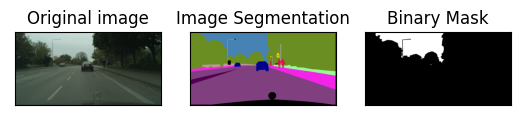

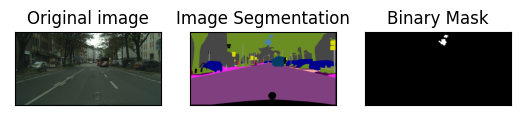

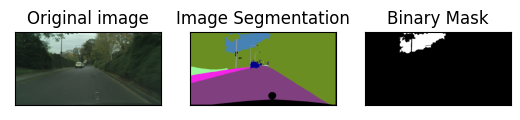

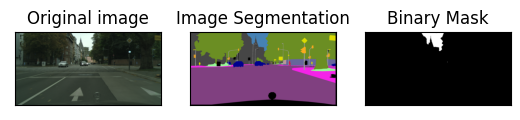

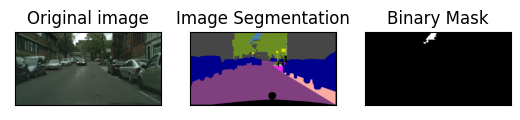

In [ ]:
# Sample and plot images from the training set
# Visualize them together with the segmentation and binary mask for the sky pixels
sample_random_images(nr_samples=NUMBER_OF_SAMPLES, train=True);

In [ ]:
# Sample and plot images from the testing set
# Visualize them together with the segmentation and binary mask for the sky pixels
sample_random_images(nr_samples=NUMBER_OF_SAMPLES, train=False);

In [ ]:
# Sample and plot images from the training set
# Visualize them together with the segmentation and binary mask for the sky pixels
sample_random_images(nr_samples=NUMBER_OF_SAMPLES, train=True);

In [ ]:
# Sample and plot images from the testing set
# Visualize them together with the segmentation and binary mask for the sky pixels
sample_random_images(nr_samples=NUMBER_OF_SAMPLES, train=False);

In [ ]:
# Sample and plot images from the testing set
# Visualize them together with the segmentation and binary mask for the car pixels
sample_random_images(nr_samples=NUMBER_OF_SAMPLES, label='car', train=False);

#### Create two balanced datasets, one sampling pixels and one patches:

Utility functions for sampling pixels and patches.

In [ ]:
def get_images_and_binary_masks(label: str = "sky", train: bool = True) -> (list, list):
    """
    Auxiliary function to get the images and the binary masks from the dataset.
    @param label: str: The class to get the masks from, supported: either sky or car.
    @param train: bool: True if the image is from the training dataset, False if it is from the testing dataset
    :return:
    """
    # get the correct path:
    path = TRAINING_DATASET_PATH if train else TESTING_DATASET_PATH

    # get all the images:
    images = []
    for image_path in glob(os.path.join(path, 'image_*.png')):
        images.append(skimage.io.imread(image_path))

    # get all the grayscale binary masks in the path:
    binary_masks = []
    for mask_path in glob(os.path.join(path, f'binary_mask_{label}_*.png')):
        binary_masks.append(skimage.io.imread(mask_path))
    # cast the binary mask to grayscale
    binary_masks = [skimage.color.rgb2gray(mask) for mask in binary_masks]

    return images, binary_masks


def get_val_images_and_binary_masks(label: str = "sky") -> (list, list):
    """
    Auxiliary function to get the images and the binary masks from the validation dataset.
    :return: the images and the binary masks from the validation dataset.
    """
    # get the correct path:
    path = VALIDATION_DATASET_PATH

    # get all the images:
    images = []
    for image_path in glob(os.path.join(path, 'image_*.png')):
        images.append(skimage.io.imread(image_path))

    # get all the grayscale binary masks in the path:
    binary_masks = []
    for mask_path in glob(os.path.join(path, f'binary_mask_{label}*.png')):
        binary_masks.append(skimage.io.imread(mask_path))

    binary_masks = [skimage.color.rgb2gray(mask) for mask in binary_masks]

    return images, binary_masks


def compute_validation_proportions(label: str = "sky") -> (int, int):
    """
    Computes the total number of pixels in the sky class in the validation dataset
    @param: label: str: the class you want to compute the validation proportions on.
    :return: the total number of pixels in the sky class and the total number of pixels in the non-sky class
    for the validation dataset.
    """
    # get the binary masks:
    binary_masks = get_val_images_and_binary_masks(label=label)[1]

    # compute the total number of pixels in the sky class
    total_sky_pixels = 0
    total_non_sky_pixels = 0
    for mask in binary_masks:
        total_sky_pixels += np.sum(mask == 1)
        total_non_sky_pixels += np.sum(mask != 1)

    # compute the sampling proportions to sample for each images
    return total_sky_pixels, total_non_sky_pixels


def validation_pixel_sampler(total_count: int, label: str = "sky") -> pd.DataFrame:
    """
    Sample pixels from the validation dataset.
    @param label: str: the class you want to sample for. Supports either sky or car.
    @param total_count: the total number of pixels to sample.
    :return: None. Saves the sampled pixels in a csv file.
    """
    # get the images and the binary masks:
    images, binary_masks = get_val_images_and_binary_masks(label=label)

    # compute the sampling proportions:
    total_sky_pixels, total_non_sky_pixels = compute_validation_proportions(label=label)

    sky_sample = total_count / total_sky_pixels
    non_sky_sample = total_count / total_non_sky_pixels

    # create the dataset
    df = pd.DataFrame(columns=['image_nr', 'r', 'g', 'b', 'x', 'y', 'class'])

    # sample the pixels
    image_count = 0
    for image, mask in zip(images, binary_masks):
        sky_row, sky_column, sky_r, sky_g, sky_b, non_sky_row, non_sky_column, non_sky_r, non_sky_g, non_sky_b = \
            binary_sampler(image, mask, sky_sample, non_sky_sample)

        # create the sky dataframe
        sky_df = pd.DataFrame(
            {'image_nr': image_count, 'r': sky_r, 'g': sky_g, 'b': sky_b, 'x': sky_column, 'y': sky_row, 'class': 1})

        # create the non-sky dataframe
        non_sky_df = pd.DataFrame(
            {'image_nr': image_count, 'r': non_sky_r, 'g': non_sky_g, 'b': non_sky_b, 'x': non_sky_column,
             'y': non_sky_row, 'class': 0})

        # concatenate the dataframes
        df = pd.concat([df, sky_df, non_sky_df], ignore_index=True)

        # increment the image count
        image_count += 1

    return df


def compute_sampling_proportions(label: str = "sky", train: bool = True) -> (int, int):
    """
    Computes the total number of pixels in the sky class in the training dataset
    @param label: str: the class you want to sample.
    @param train: True if the image is from the training dataset, False if it is from the testing dataset
    :return: the total number of pixels in the sky class
    """
    # get the binary masks:
    binary_masks = get_images_and_binary_masks(label=label, train=train)[1]

    # compute the total number of pixels in the sky class
    total_sky_pixels = 0
    total_non_sky_pixels = 0
    for mask in binary_masks:
        total_sky_pixels += np.sum(mask == 1)
        total_non_sky_pixels += np.sum(mask != 1)

    # compute the sampling proportions to sample for each images
    return total_sky_pixels, total_non_sky_pixels


def binary_sampler(image: np.ndarray, binary_mask: np.ndarray, sky_fraction: float, non_sky_fraction: float) \
        -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray,
            np.ndarray, np.ndarray):
    """
    Samples the rows, columns, and rgb values of an image for the sky and non-sky classes.
    @param image: np.ndarray: the image to sample
    @param binary_mask: np.ndarray: the binary mask of the image
    @param sky_fraction: float: the fraction of the sky pixels to sample
    @param non_sky_fraction: float: the fraction of the non-sky pixels to sample
    :return: the rows, columns, and rgb values of the sampled pixels for the sky and non-sky classes.
    """
    sky_pixels = np.argwhere(binary_mask == 1)
    # select the row index of the sky pixels
    sky_row = sky_pixels[:, 0]
    # select the column index of the sky pixels
    sky_column = sky_pixels[:, 1]
    # create tuples of the row and column index of the sky pixels
    sky_pixels = list(zip(sky_row, sky_column))
    # sample the sky pixels
    sky_pixels_index = np.random.choice(len(sky_pixels), int(len(sky_pixels) * sky_fraction), replace=False)
    sky_pixels = [sky_pixels[i] for i in sky_pixels_index]
    # get the row and column index of the sky pixels
    sky_row = [pixel[0] for pixel in sky_pixels]
    sky_column = [pixel[1] for pixel in sky_pixels]
    # get the r, g, b values of the sampled pixels
    sky_r = image[sky_row, sky_column, 0]
    sky_g = image[sky_row, sky_column, 1]
    sky_b = image[sky_row, sky_column, 2]

    # get the non-sky pixels
    non_sky_pixels = np.argwhere(binary_mask == 0)
    # select the row index of the non-sky pixels
    non_sky_row = non_sky_pixels[:, 0]
    # select the column index of the non-sky pixels
    non_sky_column = non_sky_pixels[:, 1]
    # create tuples of the x and y index of the non-sky pixels
    non_sky_pixels = list(zip(non_sky_row, non_sky_column))
    # sample the non-sky pixels
    non_sky_pixels_index = np.random.choice(len(non_sky_pixels), int(len(non_sky_pixels) * non_sky_fraction),
                                            replace=False)
    non_sky_pixels = [non_sky_pixels[i] for i in non_sky_pixels_index]
    # get the row and column index of the non-sky pixels
    non_sky_row = [pixel[0] for pixel in non_sky_pixels]
    non_sky_column = [pixel[1] for pixel in non_sky_pixels]
    # get the r, g, b values of the sampled pixels
    non_sky_r = image[non_sky_row, non_sky_column, 0]
    non_sky_g = image[non_sky_row, non_sky_column, 1]
    non_sky_b = image[non_sky_row, non_sky_column, 2]
    return sky_row, sky_column, sky_r, sky_g, sky_b, non_sky_row, non_sky_column, non_sky_r, non_sky_g, non_sky_b


def pixel_sampler(total_count: int, label: str = "sky", train: bool = True) -> pd.DataFrame:
    """
    Sample a balanced dataset, from two classes, from the images in the dataset.
    @param total_count: the total number of pixels to sample
    @param label: str: the class you want to sample for. Supports either sky or car.
    @param train: True if the image is from the training dataset, False if it is from the testing dataset
    :return: the sampled pixels
    """

    # get the images and the binary masks:
    images, binary_masks = get_images_and_binary_masks(label=label, train=train)

    # compute the sampling proportions of the two classes in the dataset:
    sky_count, non_sky_count = compute_sampling_proportions(label=label, train=train)
    sky_sample = total_count / sky_count
    non_sky_sample = total_count / non_sky_count

    # create the dataset
    df = pd.DataFrame(columns=['image_nr', 'r', 'g', 'b', 'x', 'y', 'class'])

    # sample the pixels
    image_count = 0
    for image, mask in zip(images, binary_masks):
        sky_row, sky_column, sky_r, sky_g, sky_b, non_sky_row, non_sky_column, non_sky_r, non_sky_g, non_sky_b = \
            binary_sampler(image, mask, sky_sample, non_sky_sample)

        # create the sky dataframe
        sky_df = pd.DataFrame(
            {'image_nr': image_count, 'r': sky_r, 'g': sky_g, 'b': sky_b, 'x': sky_column, 'y': sky_row, 'class': 1})

        # create the non-sky dataframe
        non_sky_df = pd.DataFrame(
            {'image_nr': image_count, 'r': non_sky_r, 'g': non_sky_g, 'b': non_sky_b, 'x': non_sky_column,
             'y': non_sky_row, 'class': 0})

        # concatenate the dataframes
        df = pd.concat([df, sky_df, non_sky_df], ignore_index=True)

        # increment the image count
        image_count += 1

    return df


def plot_binary_mask_and_sampled_pixels(pixel_dataframe: pd.DataFrame,
                                        image_nr: int, label: str = "sky", train: bool = True) -> None:
    """
    Auxiliary function to plot the binary mask and the sampled pixels
    @param pixel_dataframe: pd.DataFrame: the dataframe containing the sampled pixels
    @param image_nr: the image number: int: the image number in the dataset
    @param train: bool: True if the image is from the training dataset, False if it is from the testing dataset
    :return: None. Plots the binary mask and the sampled pixels and saves the plot to the plots' folder.
    """
    # select and create the path:
    path = TRAINING_DATASET_PATH if train else TESTING_DATASET_PATH
    plots_path = Path(SAMPLED_IMAGE_RESULTS_PATH)
    plots_path.mkdir(parents=True, exist_ok=True)

    name = 'training' if train else 'testing'

    # get the corresponding grayscale binary mask:
    binary_mask = skimage.io.imread(os.path.join(path, f'binary_mask_{label}_{image_nr}.png'))

    # get the row of the image number:
    pixels: pd.DataFrame = pixel_dataframe[pixel_dataframe['image_nr'] == image_nr]

    # labels:
    if label == "car":
        labels = ['car', 'non-car']
    else:
        labels = ['sky, non-sky']

    # plot the binary mask
    plt.imshow(binary_mask, cmap='gray', vmin=0, vmax=1)
    # plot the sampled pixels
    plt.scatter(x=pixels['x'], y=pixels['y'], c=pixels['class'], cmap='Spectral', s=1)
    # add a legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=labels,
               title='Pixel Class')
    # add a title
    plt.title(f'Sampled pixels over the binary mask, extracted from {name} image: {image_nr}.')
    # remove the axis.
    plt.axis('off')
    # save the plot
    plt.savefig(Path(plots_path, f'sampled_pixels_from_image_{image_nr}.png'))
    # remove the axis.
    plt.axis('off')
    # show the plot
    plt.show()


def sampler_visual_inspector(label: str = "sky", training: bool = True) -> None:
    """
    Visually inspect the sampler to make sure it is working properly.
    @param training: bool: True if the image is from the training dataset, False if it is from the testing dataset
    :return: None. Displays the sampled pixels on the first image in the dataset, as a sanity check.
    """
    # get the correct path:
    path = TRAINING_DATASET_PATH if training else TESTING_DATASET_PATH
    name = 'train' if training else 'test'
    type = 'by_pixel' if label == "sky" else f'by_pixel_{label}'
    df: pd.DataFrame = pd.read_csv(Path(path, f'{name}_{type}.csv'))
    # plot the binary mask and the sampled pixels
    plot_binary_mask_and_sampled_pixels(pixel_dataframe=df, image_nr=0, label=label, train=training)


def dataset_explorer(dataframe: pd.DataFrame, sampling_type: str, train: bool = True) -> None:
    """
    Function to print information on the generated dataset
    @param dataframe: the dataframe to explore
    @param sampling_type: the type of sampling used to generate the dataset, either 'pixel' or 'patch'.
    @param train: whether the dataframe is the training dataset or not
    :return: None. Prints some information.
    """

    sample_type = "pixels" if sampling_type == "pixel" else "patches"

    # print the number of rows and columns
    print("*" * 50)
    print(f"dataframe sampled by {sampling_type} has {dataframe.shape[0]} rows and "
          f"{dataframe.shape[1]} columns.")
    # print the number of sky and non-sky pixels
    print(f"dataframe sampled by {sampling_type} has {dataframe[dataframe['class'] == 1].shape[0]} "
          f"sky {sample_type} and "
          f"{dataframe[dataframe['class'] == 0].shape[0]} non-sky {sampling_type}.")

    if sampling_type == "pixel":
        # print the number of sky and non-sky pixels per image
        print(f"dataframe sampled by {sampling_type} has approximately "
              f"{int(dataframe.groupby('image_nr')['class'].sum().mean())} "
              f"sky {sample_type} per image and approximately "
              f"{int(dataframe.groupby('image_nr')['class'].count().mean() - dataframe.groupby('image_nr')['class'].sum().mean())} "
              f"non-sky {sample_type} per image.")

    elif sampling_type == "patch":
        # print the patch size
        print(f"dataframe sampled by {sampling_type} has {dataframe['patch'].shape[0]} patches of size "
              f"{dataframe['patch'].iloc[0].shape[0]}x{dataframe['patch'].iloc[0].shape[0]}.")
    # print the number of images
    print(f"dataframe sampled by {sampling_type} has {dataframe['image_nr'].nunique()} images.")
    print("*" * 50)


def has_class_delta(binary_mask: np.ndarray, delta: int = PATCH_SIZE // 2) -> bool:
    """
    Auxiliary function to check if a binary mask has sky pixels.
    @param binary_mask: the binary mask to check the presence of sky pixels.
    @param delta: the number of pixels to check around the center of the image.
    :return: bool: True if the image has sky pixels, False otherwise.
    """
    # get the mask only inside the delta for the decision:
    binary_mask = binary_mask[delta:-delta, delta:-delta]
    pixels = np.argwhere(binary_mask == 1)
    return True if len(pixels > 0) else False


def get_patches(image: np.ndarray, binary_mask: np.ndarray, n_patches: int = 6, delta: int = PATCH_SIZE // 2) \
        -> ([np.ndarray], [np.ndarray], [int], [int], [int]):
    patches: [np.ndarray] = []
    mask_labels: [np.ndarray] = []
    classes: [int] = []
    centers_row: [int] = []
    centers_column: [int] = []
    sky_count, non_sky_count = 0, 0
    for i in range(n_patches):
        while sky_count < 3:  # Get n_patches // 2 sky patches
            center_row = randint(delta, image.shape[0] - delta)
            center_column = randint(delta, image.shape[1] - delta)

            class_value = binary_mask[center_row, center_column]
            if class_value == 1:
                classes.append(class_value)
                patch = image[center_row - delta:center_row + delta, center_column - delta:center_column + delta, :]
                mask_label = binary_mask[center_row - delta:center_row + delta,
                             center_column - delta:center_column + delta]
                centers_row.append(center_row)
                centers_column.append(center_column)
                patches.append(patch)
                mask_labels.append(mask_label)
                sky_count += 1

        while non_sky_count < 3:  # Get n_patches // 2 non-sky patches
            center_row = randint(delta, image.shape[0] - delta)
            center_column = randint(delta, image.shape[1] - delta)

            class_value = binary_mask[center_row, center_column]
            if class_value == 0:
                classes.append(class_value)
                patch = image[center_row - delta: center_row + delta, center_column - delta: center_column + delta, :]
                mask_label = binary_mask[center_row - delta: center_row + delta,
                             center_column - delta: center_column + delta]
                centers_row.append(center_row)
                centers_column.append(center_column)
                patches.append(patch)
                mask_labels.append(mask_label)
                non_sky_count += 1

    return patches, mask_labels, classes, centers_row, centers_column


def patch_sampler(label: str = "sky", train: bool = True) -> pd.DataFrame:
    """
    Sample patches in the dataframe
    @param label: The class label: either sky or car.
    @param train: Whether to sample for the training set or not.
    @return: df: pd.DataFrame: the sampled dataframe.
    """
    # get all the images in the path:
    images, binary_masks = get_images_and_binary_masks(label=label, train=train)

    df = pd.DataFrame(columns=['image_nr', 'patch', 'center_x', 'center_y', 'class', 'mask_label'])
    img_num: int = 0
    for img, mask in tqdm(zip(images, binary_masks), desc='Images', total=len(images)):
        if not has_class_delta(mask):  # Skip images with no class
            img_num += 1
            continue

        patches, mask_labels, classes, centers_row, centers_column = get_patches(img, mask)

        temp_df = pd.DataFrame({'image_nr': img_num, 'patch': patches, 'mask_label': mask_labels,
                                'center_x': centers_column, 'center_y': centers_row, 'class': classes})
        df = pd.concat([df, temp_df], ignore_index=True)

        img_num += 1

    return df


def val_patch_sampler(label: str = "sky") -> pd.DataFrame:
    # get all the images in the path:
    images, binary_masks = get_val_images_and_binary_masks(label=label)

    df = pd.DataFrame(columns=['image_nr', 'patch', 'center_x', 'center_y', 'class', 'mask_label'])

    img_num: int = 0
    for img, mask in tqdm(zip(images, binary_masks), desc='Images', total=len(images)):
        if not has_class_delta(mask):  # Skip images with no class
            img_num += 1
            continue

        patches, mask_labels, classes, centers_row, centers_column = get_patches(img, mask)

        temp_df = pd.DataFrame({'image_nr': img_num, 'patch': patches, 'mask_label': mask_labels,
                                'center_x': centers_column, 'center_y': centers_row, 'class': classes})
        df = pd.concat([df, temp_df], ignore_index=True)

        img_num += 1

    return df

Create 3 balanced pixels dataset for training, validation and testing:

In [ ]:
# Sample amount of pixels per class from the training and testing dataset for the pixel classifier:
training_pixels: int = 15000
validation_pixels: int = 5000
testing_pixels: int = 5000

# Sample 15000 pixels from the training dataset:
train_pixels_df: pd.DataFrame = pixel_sampler(total_count=training_pixels, train=True)
# Sample 5000 pixels from the validation dataset:
val_pixels_df: pd.DataFrame = validation_pixel_sampler(total_count=validation_pixels)
# Sample 5000 pixels from the testing dataset:
test_pixels_df: pd.DataFrame = pixel_sampler(total_count=testing_pixels, train=False)

# Save the sampled pixels:
train_pixels_df.to_csv(Path(TRAINING_DATASET_PATH, 'train_by_pixel.csv'), index=False)
val_pixels_df.to_csv(Path(VALIDATION_DATASET_PATH, 'val_by_pixel.csv'), index=False)
test_pixels_df.to_csv(Path(TESTING_DATASET_PATH, 'test_by_pixel.csv'), index=False)

# Inspect the sampled pixels:
sampler_visual_inspector(training=True)

# Explore the pixel datasets:
dataset_explorer(dataframe=train_pixels_df, sampling_type="pixel", train=True)
dataset_explorer(dataframe=val_pixels_df, sampling_type="pixel", train=False)
dataset_explorer(dataframe=test_pixels_df, sampling_type="pixel", train=False)

In [ ]:
# Sample amount of pixels per class for the car pixel classifier:
training_pixels: int = 15000
validation_pixels: int = 5000
testing_pixels: int = 5000


# Sample 15000 pixels from the car training dataset:
train_pixels_car_df: pd.DataFrame = pixel_sampler(label="car", total_count=training_pixels, train=True)
# Sample 5000 pixels from the car validation dataset:
val_pixels_car_df: pd.DataFrame = validation_pixel_sampler(label="car", total_count=validation_pixels)
# Sample 5000 pixels from the car testing dataset:
test_pixels_car_df: pd.DataFrame = pixel_sampler(label="car", total_count=testing_pixels, train=False)

# Save the sampled car pixels:
train_pixels_car_df.to_csv(Path(TRAINING_DATASET_PATH, 'train_by_pixel_car.csv'), index=False)
val_pixels_car_df.to_csv(Path(VALIDATION_DATASET_PATH, 'val_by_pixel_car.csv'), index=False)
test_pixels_car_df.to_csv(Path(TESTING_DATASET_PATH, 'test_by_pixel_car.csv'), index=False)

In [ ]:
# Explore the sky pixel datasets:
dataset_explorer(dataframe=train_pixels_car_df, sampling_type="pixel", train=True)
dataset_explorer(dataframe=val_pixels_car_df, sampling_type="pixel", train=False)
dataset_explorer(dataframe=test_pixels_car_df, sampling_type="pixel", train=False)

In [ ]:
sampler_visual_inspector(label="car", training=True)

Sample 256x256 patches from our images and create a dataset of balanched patches:

In [ ]:
# Sample patches from the training and testing dataset for the sky patch classifier:
train_patches_df = patch_sampler(train=True)
val_patches_df = val_patch_sampler()
test_patches_df = patch_sampler(train=False)

# Save the sampled patches as pickle files to preserve the image data:
train_patches_df.to_pickle(Path(TRAINING_DATASET_PATH, 'train_by_patch.pkl'))
val_patches_df.to_pickle(Path(VALIDATION_DATASET_PATH, 'val_by_patch.pkl'))
test_patches_df.to_pickle(Path(TESTING_DATASET_PATH, 'test_by_patch.pkl'))

In [ ]:
# Explore the patch datasets:
dataset_explorer(dataframe=train_patches_df, sampling_type="patch", train=True)
dataset_explorer(dataframe=val_patches_df, sampling_type="patch", train=False)
dataset_explorer(dataframe=test_patches_df, sampling_type="patch", train=False)

Visual check that the patch-sampler works as expected:

In [ ]:
# Sample patches from the training and testing dataset for the car patch classifier:
train_patches_car_df = patch_sampler(label="car", train=True)
val_patches_car_df = val_patch_sampler(label="car")
test_patches_car_df = patch_sampler(label="car", train=False)

# Save the sampled patches as pickle files to preserve the image data:
train_patches_car_df.to_pickle(Path(TRAINING_DATASET_PATH, 'train_by_patch_car.pkl'))
val_patches_car_df.to_pickle(Path(VALIDATION_DATASET_PATH, 'val_by_patch_car.pkl'))
test_patches_car_df.to_pickle(Path(TESTING_DATASET_PATH, 'test_by_patch_car.pkl'))

In [ ]:
# Explore the patch datasets:
dataset_explorer(dataframe=train_patches_car_df, sampling_type="patch", train=True)
dataset_explorer(dataframe=val_patches_car_df, sampling_type="patch", train=False)
dataset_explorer(dataframe=test_patches_car_df, sampling_type="patch", train=False)

In [ ]:
def plot_sampled_patches(df: pd.DataFrame, n_samples: int = NUMBER_OF_SAMPLES, image_number: int = 0):
    # get all the patches with the selected image number in the dataframe
    patches = df[df['image_nr'] == image_number]['patch']
        # plot the image, the binary mask and the patches:
    fig, ax = plt.subplots(1, n_samples, figsize=(20, 10))
    for i in range(n_samples):
        ax[i].imshow(patches[i])
        ax[i].set_title(f'Patch {i}')
        ax[i].axis('off')
    plt.show()

In [ ]:
# Training data
train_image_number = 0
plt.imshow(get_image_and_segmentation(img_number=train_image_number, train=True)[0])
plt.title(f"Image {train_image_number} from Aachen:")
plt.axis('off')
plt.show()

In [ ]:
# Sky training patches
plot_sampled_patches(df=train_patches_df, n_samples=6)

In [ ]:
# Car training patches
plot_sampled_patches(df=train_patches_car_df, n_samples=6)

In [ ]:
# Testing data
test_image_number = 0
plt.imshow(get_image_and_segmentation(img_number=test_image_number, train=False)[0])
plt.title(f"Image {test_image_number} from Zürich:")
plt.axis('off')
plt.show()

In [ ]:
# Sky testing patches
plot_sampled_patches(df=test_patches_df, n_samples=6)

In [ ]:
# Car training patches
plot_sampled_patches(df=test_patches_car_df, n_samples=6)

### Modelling phase

#### Pixel Classifiers with the average RGB value as feature

We implemented two classifiers, a k-nearest neighbor and a logistic regression for this task

Utility functions for Pixel Classifier by pixel average rgb value using simple Logistic Regression

In [ ]:
def load_dataset(classification_type: str = 'by_pixel', split_type: str = 'train',
                 label: str = "sky") -> pd.DataFrame:
    """
    Loads the dataset from the path
    @param split_type: the type of split to be loaded. either train, or val, or test.
    @param classification_type: the type of classification from which to load the dataset.
    :return: the dataset
    """
    # Determine the path of the dataset
    name: str = split_type.lower()
    if name == 'train':
        path: Path = TRAINING_DATASET_PATH
    elif name == 'val':
        path: Path = VALIDATION_DATASET_PATH
    elif name == 'test':
        path: Path = TESTING_DATASET_PATH
    else:
        raise ValueError(f'Unknown split type: {split_type}')

    # select the correct dataset depending on the class you want to classify.
    subscript = "" if label == "sky" else "_" + label

    # Determine the type of classification, either by pixel or by patch
    if classification_type == 'by_pixel':
        df = pd.read_csv(Path(path, f'{name}_by_pixel{subscript}.csv'))
    elif classification_type == 'by_patch':
        # load the pickle file:
        df = pd.read_pickle(Path(path, f'{name}_by_patch{subscript}.pkl'))
    else:
        raise ValueError(f'Unknown classification type: {classification_type}')

    return df


def create_model(model_type: str = None) -> LogisticRegression or KNeighborsClassifier:
    """
    Creates a model from the dataset
    @param model_type: the type of model to create
    """
    # replicate the results
    random_seed: int = 42

    if model_type == 'logistic_regression' or type is None:
        # binary classification
        model = LogisticRegression(random_state=random_seed)
    elif model_type == 'knn':
        model = KNeighborsClassifier()
    else:
        raise ValueError(f'Unknown model type: {model_type}')

    return model


def train_model(model: LogisticRegression or KNeighborsClassifier, train: bool = True,
                label: str = "sky") \
        -> LogisticRegression or KNeighborsClassifier:
    """
    Trains the model on the dataset
    @param model: the model to train
    @param train: True if the image is from the training dataset, False if it is from the testing dataset
    @param target class: Supports sky and car.
    :return: the trained model
    """
    df = load_dataset(classification_type='by_pixel', split_type='train', label=label)
    rgb = df[['r', 'g', 'b']]
    y = df['class']
    # for the initial classifier we only care about the average RGB value of each pixel:
    x = np.array(rgb.mean(axis=1)).reshape(-1, 1)
    model.fit(x, y)
    return model


def evaluate_model(model: LogisticRegression or KNeighborsClassifier, label: str = "sky") -> float:
    """
    Evaluates the model on the dataset
    @param model: the model to evaluate
    :return: the AUC score of the model
    """
    df = load_dataset(classification_type='by_pixel', split_type='test', label=label)
    rgb = df[['r', 'g', 'b']]
    x = np.array(rgb.mean(axis=1)).reshape(-1, 1)
    y = df['class']
    # Evaluate the model on the AUC score:
    auc = roc_auc_score(y, model.predict(x))
    return auc

Create and fit Logistic Regression and K-nearest neighbors models for classifying pixels by average rgb value.

Print and save their AUC scores:

In [ ]:
# Create a Logistic regression model
log_reg = create_model(model_type='logistic_regression')
log_reg_c = create_model(model_type='logistic_regression')

# train for the sky
log_reg = train_model(log_reg)
# train for cars
log_reg_c = train_model(log_reg_c, label="car")

# Create a K-nearest neighbors model
knn = create_model(model_type='knn')
knn_c = create_model(model_type='knn')

# train for the sky
knn = train_model(knn)
# train for cars
knn_c = train_model(knn_c, label="car")

# Compute AUC score for both the models
auc_log = evaluate_model(log_reg)
auc_log_c = evaluate_model(log_reg_c, label="car")
print(f'Logistic Regression sky AUC on the test set: {auc_log:.3f}')
print(f'Logistic Regression cars AUC on the test set: {auc_log_c:.3f}')
auc_knn = evaluate_model(knn)
auc_knn_c = evaluate_model(knn_c, label="car")
print(f'KNN sky AUC on the test set: {auc_knn:.3f}')
print(f'KNN cars AUC on the test set: {auc_knn_c:.3f}')

# Ensure the results directory exists:
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

# Save the results:
results = pd.DataFrame({'model': ['logistic_regression', 'knn'],
                        'auc_sky': [auc_log, auc_knn],
                        'auc_cars': [auc_log_c, auc_knn_c]})
results.to_csv(Path(RESULTS_PATH, 'pixel_classifier_by_average_rgb.csv'), index=False)

#### Pixel Classifier using the RGB values as features

For this task we kept the Logistic Regression and K-Nearest Neighbour

Utility functions for Pixel Classifier by pixel average rgb value using simple Logistic Regression

In [ ]:
def train_model(model: LogisticRegression or KNeighborsClassifier, label: str = "sky") \
        -> LogisticRegression or KNeighborsClassifier:
    """
    Trains the model on the dataset
    @param model: the model to train
    :return: the trained model
    """
    train = load_dataset(split_type='train', label=label)
    rgb = train[['r', 'g', 'b']]
    y_train = train['class']
    # for this second classifier we take the r, g, b values of each pixel as features:
    x_train = np.array(rgb).reshape(-1, 3)
    model.fit(x_train, y_train)
    return model


def evaluate_model(model: LogisticRegression or KNeighborsClassifier, label: str ="sky") -> float:
    """
    Evaluates the model on the dataset
    @param model: the model to evaluate
    :return: the AUC score of the model
    """
    df = load_dataset(split_type='test', label=label)
    rgb = df[['r', 'g', 'b']]
    x_val = np.array(rgb).reshape(-1, 3)
    y_val = df['class']
    y_pred = model.predict_proba(x_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    return auc

Create and fit Logistic Regression and K-nearest neighbors models for classifying pixels by rgb features.

Print and save their AUC scores on the test set:

In [ ]:
# Create a Logistic regression model
log_reg = create_model(model_type='logistic_regression')
log_rec_c = create_model(model_type='logistic_regression')

# Train on sky and cars
log_reg = train_model(log_reg)
log_reg_c = train_model(log_reg_c, label="car")

# Create a K-nearest neighbors model
knn = create_model(model_type='knn')
knn_c = create_model(model_type='knn')

# train on sky and cars
knn = train_model(knn)
knn_c = train_model(knn_c, label="car")

# Compute AUC score for both the models and classes:
auc_log = evaluate_model(log_reg)
print(f'Logistic Regression sky AUC on the test set: {auc_log:.3f}')
auc_knn = evaluate_model(knn)
print(f'KNN sky AUC on the test set: {auc_knn:.3f}')

auc_log_c = evaluate_model(log_reg_c, label="car")
print(f'Logistic Regression sky AUC on the test set: {auc_log_c:.3f}')
auc_knn_c = evaluate_model(knn_c, label="car")
print(f'KNN sky AUC on the test set: {auc_knn_c:.3f}')

# Ensure the results directory exists:
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

# Save the results:
results = pd.DataFrame({'model': ['logistic_regression', 'knn'],
                        'auc_sky': [auc_log, auc_knn],
                        'auc_car': [auc_log_c, auc_knn_c]})

results.to_csv(Path(RESULTS_PATH, 'pixel_classifier_by_rgb_as_feature.csv'), index=False)

#### Patch segmentation using a Feed-Forward Neural Network

Utility functions for patch segmentation using a Feed-Forward Neural Network

In [ ]:
def create_ff_nn_model(nr_neurons_layer_1: int = 256, nr_neurons_layer_2: int = 128, dropout_rate: float = 0.1) -> Sequential:
    """
    Create a feed forward neural network with 2 hidden layers and a sigmoid output layer.
    @param nr_neurons_layer_1: number of neurons in the first hidden layer
    @param nr_neurons_layer_2: number of neurons in the second hidden layer
    @param dropout_rate: dropout rate
    :return: Sequential: the model.
    """

    # Create a fully connected model:
    model = Sequential()
    # the input layer are the number of patches of 256x256 pixels, each with 3 channels (RGB):
    model.add(Flatten(input_shape=(PATCH_SIZE, PATCH_SIZE, 3)))
    # add a dense layer:
    model.add(Dense(nr_neurons_layer_1, activation='relu'))
    # add a dropout layer to prevent over-fitting:
    model.add(Dropout(dropout_rate))
    # second dense layer:
    model.add(Dense(nr_neurons_layer_2, activation='relu'))
    # add a dropout layer to prevent over-fitting:
    model.add(Dropout(dropout_rate))
    # the output layer is a binary mask of 256x256 pixels, 0 for background and 1 for sky:
    model.add(Dense(PATCH_SIZE * PATCH_SIZE, activation='sigmoid'))
    # reshape the output to be a 256x256 mask:
    model.add(Reshape((PATCH_SIZE, PATCH_SIZE, 1)))

    # compile the model:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

    return model


def visualize_segmentation(image: np.ndarray, generated_segmentation: np.ndarray, binary_mask: np.ndarray,
                           path: Union[str, Path], save: bool = False) -> None:
    """
    Visualize the segmentation of an image superimposed on the original image.
    show the binary mask on the right.
    @param image: np.ndarray: the original image
    @param generated_segmentation: np.ndarray: the generated segmentation
    @param binary_mask: np.ndarray: the binary mask of the image
    @param save: bool: whether to save the plot
    @param path: Path or str: the path to save the plot to
    :return: None, shows the plot and optionally saves it.
    """

    # plot the image and superimpose the segmentation on the left, the segmentation on its own in the center as
    # a subplot and the binary mask on the right as a subplot:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
    ax1.imshow(image, vmin=0, vmax=1)
    # remove the axis:
    ax1.axis('off')
    ax1.set_title('Patch')
    ax2.imshow(generated_segmentation, vmin=0, vmax=1, cmap='gray')
    # remove the axis:
    ax2.axis('off')
    ax2.set_title(f'Generated segmentation')
    ax3.imshow(binary_mask, vmin=0, vmax=1, cmap='gray')
    # remove the axis:
    ax3.axis('off')
    ax3.set_title(f'Original binary mask')

    # save the plot if required:
    if save:
        plt.savefig(path)

    # show the plot:
    plt.show()
    
    
def plot_history(history, fig_name: str) -> None:
    # Plot the epochs history with accuracy and loss function values at each epoch
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    save_fig(fig_name)
    plt.xlabel('Epoch')
    plt.ylabel('Scores')
    plt.show()
    
def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    if tight_layout:
        plt.tight_layout()
    plt.savefig(fig_name, dpi=resolution)

Load the train, test and validation sets and preprocess them, for sky classification.

In [ ]:
# Load training, validation and testing sets
train = load_dataset(classification_type='by_patch', split_type='train')
val = load_dataset(classification_type='by_patch', split_type='val')
test = load_dataset(classification_type='by_patch', split_type='test')

# Preprocess the data:
# get the raw features and labels:
x_train = train['patch']
y_train = train['mask_label']
x_val = val['patch']
y_val = val['mask_label']
x_test = test['patch']
y_test = test['mask_label']

# preprocess the data, convert to float32 and normalize to [0, 1]:
x_train = np.array(x_train.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)).astype(np.float32) / 255
x_val = np.array(x_val.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)).astype(np.float32) / 255
x_test = np.array(x_test.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)).astype(np.float32) / 255
y_train = np.array(y_train.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 1)).astype(np.float32)
y_val = np.array(y_val.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 1)).astype(np.float32)
y_test = np.array(y_test.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 1)).astype(np.float32)

Create, fit and evaluate the Feed-forward neural network:

In [ ]:
# Create the Feed-Forward Neural Network model
ff_nn_model = create_ff_nn_model()

# Train the model:
history_ffnn = ff_nn_model.fit(x_train, y_train, epochs=5, batch_size=32,
                               validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.TensorBoard(log_dir=log_path)])

# Evaluate the model on the AUC metric:
y_pred = ff_nn_model.predict(x_test)

# Flatten for the AUC metric:
y_pred_flat = y_pred.ravel()
y_test_flat = y_test.ravel()

# Calculate the AUC:
auc_ff_nn = roc_auc_score(y_test_flat, y_pred_flat)
print(f'The AUC on the test set is: {auc_ff_nn}')

# Ensure the results directory exists:
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
# Save the results:
results = pd.DataFrame({'model': ['dense'], 'auc': [auc_ff_nn]})
results.to_csv(Path(RESULTS_PATH, 'segmentation_by_patch_classification_feed_forward.csv'), index=False)

# Get 10 random images from the test set:
random_indexes = np.random.choice(range(len(x_test)), NUMBER_OF_SAMPLES)
for i in random_indexes:
    # get the image and the segmentation:
    image = x_test[i]
    # get the binary mask:
    binary_mask = y_test[i]
    generated_segmentation = y_pred[i]
    # visualize the image and the segmentation:
    visualize_segmentation(image=image, 
                           generated_segmentation=generated_segmentation, 
                           binary_mask=binary_mask,
                           save=True,
                           path=Path(SAMPLED_IMAGE_RESULTS_PATH,
                                     f'test_image_{i}_segmentation_by_patch_classification_feed_forward.png'))

In [ ]:
# Plot the learning curves of the Feed Forward NN
plot_history(history_ffnn, str(Path(LEARNING_CURVE_GRAPHS, f'ffnn_learning_curves.png')))

#### Patch segmentation using a simple Convolutional Neural Network

Utility functions for pacth segmentation using a Convolutional Neural Network

In [ ]:
def create_cnn_model() -> Model:
    input_layer = Input(shape=(None, None, 3))
    x = Conv2D(filters=2, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    x = Conv2D(filters=4, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation='sigmoid')(x)
    return Model(input_layer, x)

Create, fit and evaluate the Convolutional Neural Network:

In [ ]:
# Create the Convolutional Neural Network model
cnn_model = create_cnn_model()

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Train the model
history_cnn_sky = cnn_model.fit(x_train, y_train, epochs=8, batch_size=32, validation_data=(x_val, y_val),
                                callbacks=[tf.keras.callbacks.TensorBoard(log_dir=str(log_path), histogram_freq=1)])

In [ ]:
# Evaluate the model:
y_pred = cnn_model.predict(x_test)

# Flatten for the AUC metric:
y_pred_flat = y_pred.ravel()
y_test_flat = y_test.ravel()

# Calculate the AUC:
auc_cnn_simple = roc_auc_score(y_test_flat, y_pred_flat)
print(f'The AUC on the test set is: {auc_cnn_simple}')

# Save the results:
results_path = Path(RESULTS_PATH)
results_path.mkdir(parents=True, exist_ok=True)
results = pd.DataFrame({'auc': [auc_cnn_simple]})
results_path /= 'auc_cnn_simple.csv'
results.to_csv(results_path, index=False)

# Get 10 random images from the test set:
random_indexes = np.random.choice(range(len(x_test)), NUMBER_OF_SAMPLES)
for i in random_indexes:
    # get the image and the segmentation:
    image = x_test[i]
    # get the binary mask:
    binary_mask = y_test[i]
    generated_segmentation = y_pred[i]
    # visualize the image and the segmentation:
    visualize_segmentation(image=image,
                           generated_segmentation=generated_segmentation,
                           binary_mask=binary_mask,
                           save=True,
                           path=Path(SAMPLED_IMAGE_RESULTS_PATH,
                                     f'test_image_{i}_segmentation_by_patch_classification_simple_cnn.png'))

In [ ]:
# Plot the learning curves of the CNN
plot_history(history_cnn_sky, str(Path(LEARNING_CURVE_GRAPHS, f'cnn_sky_learning_curves.png')))

In [ ]:
# Save the cnn model in a pickle file
model_folder: Path = Path(RESULTS_PATH, "models")
model_folder.mkdir(parents=True, exist_ok=True)

pickle.dump(cnn_model, open(str(Path(model_folder, "simple_cnn.pkl")), 'wb'));

#### Patch segmentation using a U-Net Convolutional Neural Network

Utility functions for pacth segmentation using a U-Net Convolutional Neural Network

In [ ]:
def create_unet_cnn_model() -> Model:
    """
    Creates a U-Net model, copied from professor Giusti's jupyter notebook fcn.ipynb.
    @return: Model, the U-Net model.
    """
    input_layer = Input(shape=(None, None, 3), name='input')
    x = Conv2D(filters=4, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = SeparableConv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x1 = x
    x = MaxPooling2D(2)(x)
    x = SeparableConv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x2 = x
    x = MaxPooling2D(2)(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(2)(x)
    x = Concatenate()([x, x2]) # Skip connections
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(2)(x)
    x = Concatenate()([x, x1])  # Skip connections
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation='sigmoid')(x)
    return Model(input_layer, x)

Create, fit and evaluate the U-Net Convolutional Neural Network:

In [ ]:
# Create the U-Net Convolutional Neural Network model
unet_model = create_unet_cnn_model()

# Compile the model
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Train the model
history_unet_sky = unet_model.fit(x_train, y_train, epochs=12, batch_size=128,
                                  validation_data=(x_val, y_val),
                                  callbacks=[tf.keras.callbacks.TensorBoard(log_dir=str(log_path), histogram_freq=1)])

In [ ]:
# Evaluate the model:
y_pred = unet_model.predict(x_test)

# Flatten for the AUC metric:
y_pred_flat = y_pred.ravel()
y_test_flat = y_test.ravel()

# Calculate the AUC:
auc_cnn_unet = roc_auc_score(y_test_flat, y_pred_flat)
print(f'The AUC on the test set is: {auc_cnn_unet}')

# Save the results:
results_path = Path(RESULTS_PATH)
results_path.mkdir(parents=True, exist_ok=True)
results = pd.DataFrame({'auc': [auc_cnn_unet]})
results_path /= 'auc_cnn_unet.csv'
results.to_csv(results_path, index=False)

# Get random images from the test set:
random_indexes = np.random.choice(range(len(x_test)), NUMBER_OF_SAMPLES)
for i in random_indexes:
    # get the image and the segmentation:
    image = x_test[i]
    # get the binary mask:
    binary_mask = y_test[i]
    generated_segmentation = y_pred[i]
    # visualize the image and the segmentation:
    visualize_segmentation(image=image,
                           generated_segmentation=generated_segmentation,
                           binary_mask=binary_mask,
                           save=True,
                           path=Path(SAMPLED_IMAGE_RESULTS_PATH,
                                     f'test_image_{i}_segmentation_by_patch_classification_unet_cnn.png'))

In [ ]:
# Plot the learning curves of the UNET
plot_history(history_unet_sky, str(Path(LEARNING_CURVE_GRAPHS, f'unet_sky_learning_curves.png')))

In [ ]:
# Save the unet model in a pickle file
model_folder: Path = Path(RESULTS_PATH, "models")
model_folder.mkdir(parents=True, exist_ok=True)

pickle.dump(cnn_model, open(str(Path(model_folder, "unet_cnn.pkl")), 'wb'))

Test the Convolutional Neural Network on a complete image:

In [ ]:
# Let the CNN segment the first image in the test set
test_image_number = 0
zurich_image = get_image_and_segmentation(img_number=test_image_number, train=False)[0].astype(np.float32) / 255

plt.imshow(zurich_image)
plt.title(f"Image {test_image_number} from Zürich:")
plt.axis('off')
plt.show()

zurich_image = np.expand_dims(zurich_image, axis=0)

In [ ]:
# Get the image segmentation using the CNN model
zurich_segmentation = cnn_model.predict(zurich_image)

# Plot the image CNN segmentation
zurich_segmentation = zurich_segmentation.reshape(1024, 2048)
plt.imshow(zurich_segmentation, cmap='gray', vmin=0, vmax=1)
plt.title(f"Image {test_image_number} from Zürich, segmentation using CNN:")
plt.axis('off')
plt.show()

In [ ]:
# Try thresholding the segmentation from CNN
zurich_image_thresholding = np.where(zurich_segmentation > 0.85, 1, 0)

# Plot the image CNN segmentation with thresholding
zurich_image_thresholding = zurich_image_thresholding.reshape(1024, 2048)
plt.imshow(zurich_image_thresholding, cmap='gray', vmin=0, vmax=1)
plt.title(f"Image {test_image_number} from Zürich, segmentation using UNET:")
plt.axis('off')
plt.show()

Test the UNET Convolutional Neural Network on a complete image:

In [ ]:
# Get the image segmentation using the UNET model
zurich_segmentation = unet_model.predict(zurich_image)

# Plot the image UNET segmentation
zurich_segmentation = zurich_segmentation.reshape(1024, 2048)
plt.imshow(zurich_segmentation, cmap='gray', vmin=0, vmax=1)
plt.title(f"Image {test_image_number} from Zürich, segmentation using UNET:")
plt.axis('off')
plt.show()

In [ ]:
# Try thresholding the segmentation from UNET
zurich_image_thresholding = np.where(zurich_segmentation > 0.3, 1, 0)

# Plot the image UNET segmentation with thresholding
zurich_image_thresholding = zurich_image_thresholding.reshape(1024, 2048)
plt.imshow(zurich_image_thresholding, cmap='gray', vmin=0, vmax=1)
plt.title(f"Image {test_image_number} from Zürich, segmentation using UNET:")
plt.axis('off')
plt.show()

#### Load the train, test and validation sets and preprocess them, for cars classification.

In [ ]:
# Load training, validation and testing sets
train = load_dataset(classification_type='by_patch', split_type='train', label="car")
val = load_dataset(classification_type='by_patch', split_type='val', label="car")
test = load_dataset(classification_type='by_patch', split_type='test', label="car")

# Preprocess the data:
# get the raw features and labels:
x_train_c = train['patch']
y_train_c = train['mask_label']
x_val_c = val['patch']
y_val_c = val['mask_label']
x_test_c = test['patch']
y_test_c = test['mask_label']

# preprocess the data, convert to float32 and normalize to [0, 1]:
x_train_c = np.array(x_train.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)).astype(np.float32) / 255
x_val_c = np.array(x_val.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)).astype(np.float32) / 255
x_test_c = np.array(x_test.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)).astype(np.float32) / 255
y_train_c = np.array(y_train.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 1)).astype(np.float32)
y_val_c = np.array(y_val.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 1)).astype(np.float32)
y_test_c = np.array(y_test.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 1)).astype(np.float32)

Select the CNN model and train it as usual, change the label for other classes:

In [ ]:
# Create the Convolutional Neural Network model
cnn_model_c = create_cnn_model()

# Compile the model
cnn_model_c.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Train the model
history_cnn_car = cnn_model_c.fit(x_train, y_train, epochs=8, batch_size=32, validation_data=(x_val, y_val),
                                callbacks=[tf.keras.callbacks.TensorBoard(log_dir=str(log_path), histogram_freq=1)])

In [ ]:
# Evaluate the model:
y_pred_c = cnn_model_c.predict(x_test)

# Flatten for the AUC metric:
y_pred_flat_c = y_pred_c.ravel()
y_test_flat_c = y_test_c.ravel()

# Calculate the AUC:
auc_cnn_simple_c = roc_auc_score(y_test_flat_c, y_pred_flat_c)
print(f'The AUC on the test set is: {auc_cnn_simple_c}')

# Save the results:
results_path = Path(RESULTS_PATH)
results_path.mkdir(parents=True, exist_ok=True)
results = pd.DataFrame({'auc': [auc_cnn_simple_c]})
results_path /= 'auc_cnn_simple_cars.csv'
results.to_csv(results_path, index=False)

# Get 10 random images from the test set:
random_indexes = np.random.choice(range(len(x_test_c)), NUMBER_OF_SAMPLES)
for i in random_indexes:
    # get the image and the segmentation:
    image = x_test_c[i]
    # get the binary mask:
    binary_mask = y_test_c[i]
    generated_segmentation = y_pred_c[i]
    # visualize the image and the segmentation:
    visualize_segmentation(image=image,
                           generated_segmentation=generated_segmentation,
                           binary_mask=binary_mask,
                           save=True,
                           path=Path(SAMPLED_IMAGE_RESULTS_PATH,
                                     f'test_image_{i}_segmentation_by_patch_classification_simple_cnn_cars.png'))

In [ ]:
# Plot the learning curves of the CNN
plot_history(history_cnn_car, str(Path(LEARNING_CURVE_GRAPHS, f'cnn_car_learning_curves.png')))

Test the Convolutional Neural Network on a complete image:

In [ ]:
# Let the CNN segment the first image in the test set
test_image_number = 0
zurich_image = get_image_and_segmentation(img_number=test_image_number, train=False)[0].astype(np.float32) / 255

plt.imshow(zurich_image)
plt.title(f"Image {test_image_number} from Zürich:")
plt.axis('off')
plt.show()

zurich_image = np.expand_dims(zurich_image, axis=0)

In [ ]:
# Get the image segmentation using the UNET model
zurich_segmentation = cnn_model_c.predict(zurich_image)

# Plot the image UNET segmentation
zurich_segmentation = zurich_segmentation.reshape(1024, 2048)
plt.imshow(zurich_segmentation, cmap='gray', vmin=0, vmax=1)
plt.title(f"Image {test_image_number} from Zürich, segmentation using CNN:")
plt.axis('off')
plt.show()

In [ ]:
# Try thresholding the segmentation from UNET
zurich_image_thresholding = np.where(zurich_segmentation > 0.85, 1, 0)

# Plot the image UNET segmentation with thresholding
zurich_image_thresholding = zurich_image_thresholding.reshape(1024, 2048)
plt.imshow(zurich_image_thresholding, cmap='gray', vmin=0, vmax=1)
plt.title(f"Image {test_image_number} from Zürich, segmentation using CNN:")
plt.axis('off')
plt.show()

Select the UNET model and train it as usual, change the label for other classes:

In [ ]:
# Create the U-Net Convolutional Neural Network model
unet_model_c = create_unet_cnn_model()

# Compile the model
unet_model_c.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Train the model
history_unet_car = unet_model_c.fit(x_train_c, y_train_c, epochs=20, batch_size=128,
                                    validation_data=(x_val, y_val),
                                    callbacks=[tf.keras.callbacks.TensorBoard(log_dir=str(log_path), histogram_freq=1)])
# Evaluate the model:
y_pred_c = unet_model_c.predict(x_test_c)

# Flatten for the AUC metric:
y_pred_flat_c = y_pred_c.ravel()
y_test_flat_c = y_test_c.ravel()

# Calculate the AUC:
auc_cnn_unet_c = roc_auc_score(y_test_flat_c, y_pred_flat_c)
print(f'The AUC on the test set is: {auc_cnn_unet_c}')

# Save the results:
results_path = Path(RESULTS_PATH)
results_path.mkdir(parents=True, exist_ok=True)
results = pd.DataFrame({'auc_car': [auc_cnn_unet_c]})
results_path /= 'auc_cnn_unet_cars.csv'
results.to_csv(results_path, index=False)

# Get random images from the test set:
random_indexes = np.random.choice(range(len(x_test_c)), NUMBER_OF_SAMPLES)
for i in random_indexes:
    # get the image and the segmentation:
    image = x_test_c[i]
    # get the binary mask:
    binary_mask = y_test_c[i]
    generated_segmentation = y_pred_c[i]
    # visualize the image and the segmentation:
    visualize_segmentation(image=image,
                           generated_segmentation=generated_segmentation,
                           binary_mask=binary_mask,
                           save=True,
                           path=Path(SAMPLED_IMAGE_RESULTS_PATH,
                                     f'test_image_{i}_segmentation_by_patch_classification_unet_cnn_cars.png'))

In [ ]:
# Plot the learning curves of the UNET
plot_history(history_unet_car, str(Path(LEARNING_CURVE_GRAPHS, f'unet_car_learning_curves.png')))

Test the UNET Convolutional Neural Network on a complete image:

In [ ]:
# Let the CNN segment the first image in the test set
test_image_number = 0
zurich_image = get_image_and_segmentation(img_number=test_image_number, train=False)[0].astype(np.float32) / 255

plt.imshow(zurich_image)
plt.title(f"Image {test_image_number} from Zürich:")
plt.axis('off')
plt.show()

zurich_image = np.expand_dims(zurich_image, axis=0)

In [ ]:
# Get the image segmentation using the UNET model
zurich_segmentation = unet_model_c.predict(zurich_image)

# Plot the image UNET segmentation
zurich_segmentation = zurich_segmentation.reshape(1024, 2048)
plt.imshow(zurich_segmentation, cmap='gray', vmin=0, vmax=1)
plt.title(f"Image {test_image_number} from Zürich, segmentation using UNET:")
plt.axis('off')
plt.show()

In [ ]:
# Try thresholding the segmentation from UNET
zurich_image_thresholding = np.where(zurich_segmentation > 0.3, 1, 0)

# Plot the image UNET segmentation with thresholding
zurich_image_thresholding = zurich_image_thresholding.reshape(1024, 2048)
plt.imshow(zurich_image_thresholding, cmap='gray', vmin=0, vmax=1)
plt.title(f"Image {test_image_number} from Zürich, segmentation using UNET:")
plt.axis('off')
plt.show()